<a href="https://www.kaggle.com/code/syedahafsasalman/winter-fashion-analytics-deep-insights-with-ml-ai?scriptVersionId=283677460" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/winter-fashoin-trends/Winter_Fashion_Trends_Dataset.csv


# Winter Fashion Trends — EDA, Insights & Models

# Winter Fashion Trends — EDA, Insights & Models
**Author:** Syeda Hafsa Salman  
**Dataset:** Winter_Fashoin Trends (Winter_Fashion_Trends_Dataset.csv). Source: Kaggle. :contentReference[oaicite:2]{index=2}

**Notebook overview**
- Exploratory Data Analysis (EDA)
- Visualizations & trend insights
- Feature engineering
- Predictive modeling:
  - Classification: predict `trend_status` (e.g., Trending vs Outdated)
  - Regression: predict `popularity` or `price`
- Clustering / customer segments
- Content-based recommender for similar items


# Imports & display settings

In [2]:
# Standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Optional: XGBoost (available on Kaggle)
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

# Plot settings
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


# Locate & load CSV

In [3]:
# If you are on Kaggle the dataset is usually mounted under /kaggle/input/
base = Path('/kaggle/input')
print("Top-level directories in /kaggle/input:", os.listdir(base) if base.exists() else "Not on Kaggle environment")

# Try to find CSV automatically
csv_path = None
for root, dirs, files in os.walk('/kaggle/input'):
    for f in files:
        if f.lower().startswith('winter') and f.lower().endswith('.csv'):
            csv_path = os.path.join(root, f)
            break
    if csv_path:
        break

# If not on Kaggle or not found, fallback to path provided by user (update manually if needed)
if csv_path is None:
    csv_path = '/kaggle/working/Winter_Fashion_Trends_Dataset.csv'  # change if necessary

print("Using CSV path:", csv_path)
df = pd.read_csv(csv_path)
df.head()


Top-level directories in /kaggle/input: ['winter-fashoin-trends']
Using CSV path: /kaggle/input/winter-fashoin-trends/Winter_Fashion_Trends_Dataset.csv


,ID,Brand,Category,Color,Material,Style,Gender,Season,Price(USD),Popularity_Score,Customer_Rating,Trend_Status
0,1,Adidas,Gloves,Brown,Polyester,Streetwear,Women,Winter 2025,244.06,6.0,4.9,Trending
1,2,Gucci,Gloves,Red,Leather,Sporty,Men,Winter 2023,366.73,8.8,3.3,Trending
2,3,H&M,Coat,Brown,Fleece,Streetwear,Unisex,Winter 2025,741.55,4.8,3.5,Trending
3,4,North Face,Coat,Blue,Cashmere,Formal,Men,Winter 2024,116.09,7.5,3.1,Outdated
4,5,Mango,Thermal,Blue,Cashmere,Formal,Unisex,Winter 2025,193.16,7.8,4.3,Outdated


# Quick dataset summary

### Quick look: rows, columns, dtypes, missing values


In [4]:
print("Shape:", df.shape)
display(df.info())
display(df.describe(include='all').T)
# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Missing values:\n", missing)


Shape: (150, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                150 non-null    int64  
 1   Brand             150 non-null    object 
 2   Category          150 non-null    object 
 3   Color             150 non-null    object 
 4   Material          150 non-null    object 
 5   Style             150 non-null    object 
 6   Gender            150 non-null    object 
 7   Season            150 non-null    object 
 8   Price(USD)        150 non-null    float64
 9   Popularity_Score  150 non-null    float64
 10  Customer_Rating   150 non-null    float64
 11  Trend_Status      150 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 14.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,150.0,NaN,NaN,NaN,75.5,43.445368,1.0,38.25,75.5,112.75,150.0
Brand,150,10,Mango,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,150,10,Scarf,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Color,150,10,Beige,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Material,150,7,Cotton,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Style,150,5,Sporty,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,150,3,Unisex,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Season,150,3,Winter 2025,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price(USD),150.0,NaN,NaN,NaN,443.105933,211.630074,30.07,292.8075,445.82,631.5375,788.03
Popularity_Score,150.0,NaN,NaN,NaN,5.763333,2.655763,1.1,3.4,5.85,8.225,10.0


Missing values:
 Series([], dtype: int64)


# Clean column names & sample values

In [5]:
# Clean column names: strip, lower, replace spaces with _
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
df.rename(columns=lambda x: x.lower(), inplace=True)
df.head()


,id,brand,category,color,material,style,gender,season,price(usd),popularity_score,customer_rating,trend_status
0,1,Adidas,Gloves,Brown,Polyester,Streetwear,Women,Winter 2025,244.06,6.0,4.9,Trending
1,2,Gucci,Gloves,Red,Leather,Sporty,Men,Winter 2023,366.73,8.8,3.3,Trending
2,3,H&M,Coat,Brown,Fleece,Streetwear,Unisex,Winter 2025,741.55,4.8,3.5,Trending
3,4,North Face,Coat,Blue,Cashmere,Formal,Men,Winter 2024,116.09,7.5,3.1,Outdated
4,5,Mango,Thermal,Blue,Cashmere,Formal,Unisex,Winter 2025,193.16,7.8,4.3,Outdated


# EDA: Unique counts & top categories

In [6]:
cat_cols = ['brand','category','material','style','gender','trend_status']
for c in cat_cols:
    if c in df.columns:
        print(f"--- {c} ---")
        display(df[c].value_counts().head(10))


--- brand ---


brand
Mango         25
North Face    20
Uniqlo        16
Prada         16
H&M           15
Gucci         14
Zara          13
Nike          13
Adidas        10
Levi's         8
Name: count, dtype: int64

--- category ---


category
Scarf       23
Thermal     19
Gloves      18
Sweater     17
Coat        14
Jacket      14
Beanie      12
Cardigan    11
Hoodie      11
Boots       11
Name: count, dtype: int64

--- material ---


material
Cotton       29
Fleece       27
Leather      22
Cashmere     21
Polyester    19
Down         19
Wool         13
Name: count, dtype: int64

--- style ---


style
Sporty        34
Streetwear    32
Formal        32
Luxury        30
Casual        22
Name: count, dtype: int64

--- gender ---


gender
Unisex    55
Women     50
Men       45
Name: count, dtype: int64

--- trend_status ---


trend_status
Outdated    50
Trending    42
Emerging    30
Classic     28
Name: count, dtype: int64

# Visual: Top brands, categories, materials

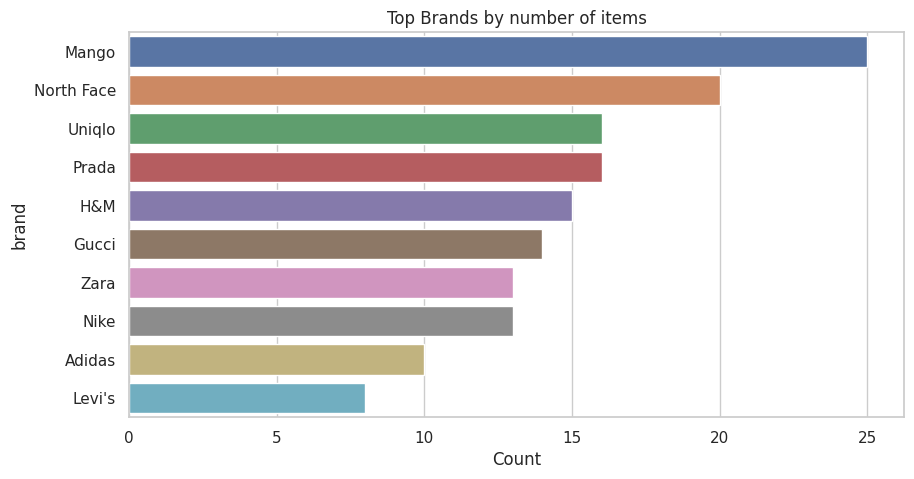

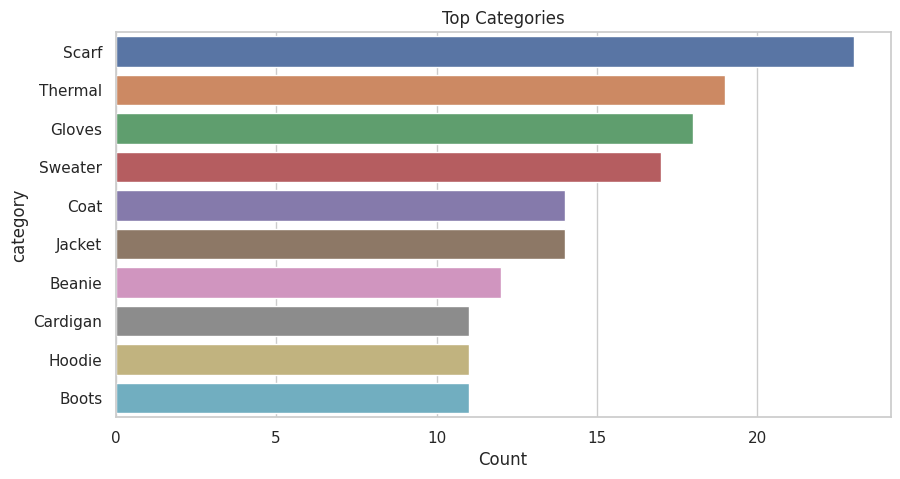

In [7]:
# Top brands
if 'brand' in df.columns:
    top_brands = df['brand'].value_counts().nlargest(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_brands.values, y=top_brands.index)
    plt.title('Top Brands by number of items')
    plt.xlabel('Count')
    plt.show()

# Top categories
if 'category' in df.columns:
    top_cat = df['category'].value_counts().nlargest(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_cat.values, y=top_cat.index)
    plt.title('Top Categories')
    plt.xlabel('Count')
    plt.show()


# Numeric exploration: price, popularity, rating

In [8]:
num_cols = []
for c in ['price','popularity','customer_rating','rating','review_count']:
    if c in df.columns:
        num_cols.append(c)

df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
customer_rating,150.0,3.802667,0.719428,2.5,3.125,3.8,4.4,5.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


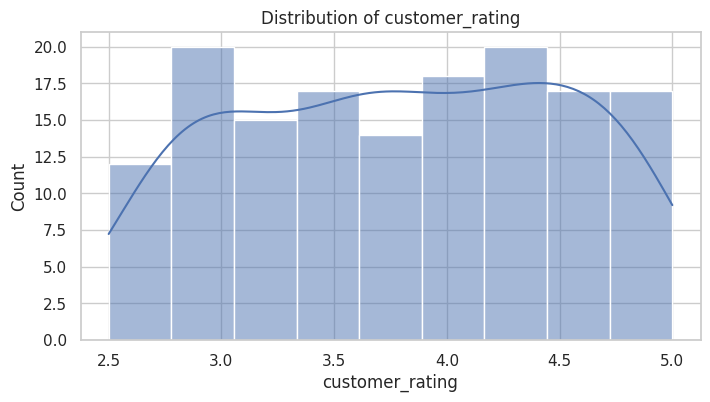

In [9]:
for c in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[c].dropna(), kde=True)
    plt.title(f'Distribution of {c}')
    plt.show()


# Correlation heatmap & pairwise relationships

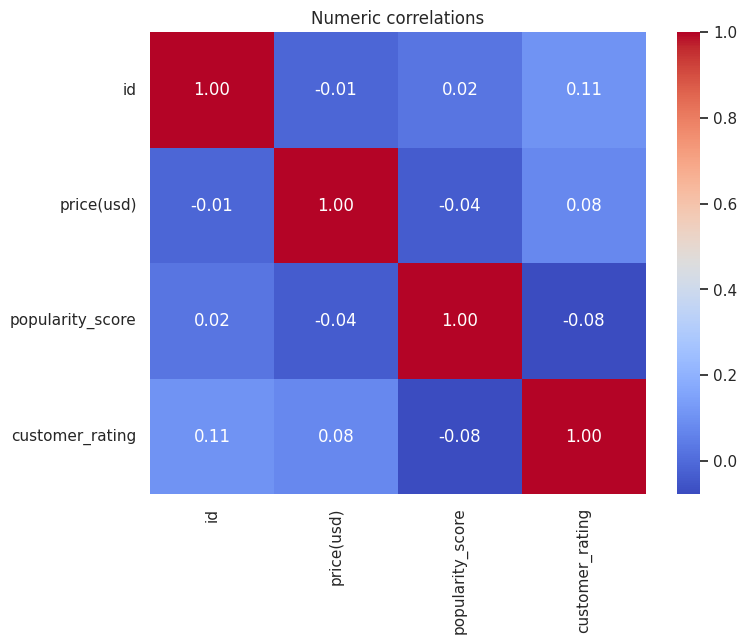

In [10]:
# Correlation between numeric columns
numeric = df.select_dtypes(include=[np.number])
if not numeric.empty:
    plt.figure(figsize=(8,6))
    sns.heatmap(numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Numeric correlations')
    plt.show()

# Scatter: popularity vs price and rating
for y in ['popularity','customer_rating','rating']:
    if y in df.columns and 'price' in df.columns:
        plt.figure(figsize=(8,5))
        sns.scatterplot(data=df, x='price', y=y, hue='brand' if 'brand' in df.columns else None, legend=False)
        plt.title(f'{y} vs price')
        plt.show()


# Create a is_trending label and balance check

### We will derive a binary label `is_trending` from `trend_status` (e.g., 'Trending' / 'Outdated').


In [11]:
# Inspect unique trend_status values
if 'trend_status' in df.columns:
    print(df['trend_status'].value_counts())

# Map to binary
trend_map = {}
if 'trend_status' in df.columns:
    # Example mapping - adapt if values differ
    trend_map = {v: (1 if 'trend' in str(v).lower() or 'trending' in str(v).lower() else 0) for v in df['trend_status'].unique()}
    df['is_trending'] = df['trend_status'].map(trend_map).astype(int)
    print("Mapping used:", trend_map)
    print("is_trending value counts:\n", df['is_trending'].value_counts())
else:
    print("No trend_status column found.")


trend_status
Outdated    50
Trending    42
Emerging    30
Classic     28
Name: count, dtype: int64
Mapping used: {'Trending': 1, 'Outdated': 0, 'Classic': 0, 'Emerging': 0}
is_trending value counts:
 is_trending
0    108
1     42
Name: count, dtype: int64


# Feature engineering (price bins, text join for content features)

In [12]:
# Show new features without assuming columns exist
show_cols = []

# Only add columns if they are actually in the dataframe
for col in ['price', 'price_bin', 'is_trending']:
    if col in df.columns:
        show_cols.append(col)

# Add text columns (brand, category, style, material, gender)
text_cols = [c for c in ['brand','category','style','material','gender'] if c in df.columns]
show_cols += text_cols

df[show_cols].head()



,is_trending,brand,category,style,material,gender
0,1,Adidas,Gloves,Streetwear,Polyester,Women
1,1,Gucci,Gloves,Sporty,Leather,Men
2,1,H&M,Coat,Streetwear,Fleece,Unisex
3,0,North Face,Coat,Formal,Cashmere,Men
4,0,Mango,Thermal,Formal,Cashmere,Unisex


# Simple classification baseline: Logistic Regression / Random Forest

In [13]:
# Prepare features
features = []
if 'price' in df.columns:
    features.append('price')
if 'customer_rating' in df.columns:
    features.append('customer_rating')
# One-hot encode categorical: brand, category, style (limit top N)
top_brands = df['brand'].value_counts().nlargest(20).index.tolist() if 'brand' in df.columns else []
df['brand_top'] = df['brand'].where(df['brand'].isin(top_brands), 'other') if 'brand' in df.columns else None

# Build dataframe for modeling
mod_df = df.copy()
# Drop rows with missing target
mod_df = mod_df[~mod_df['is_trending'].isnull()]

# Select columns for simple model
model_cat = []
if 'brand_top' in mod_df.columns:
    model_cat.append('brand_top')
if 'category' in mod_df.columns:
    model_cat.append('category')
if 'material' in mod_df.columns:
    model_cat.append('material')

X = mod_df[features + model_cat].copy()
y = mod_df['is_trending']

# Preprocessing pipeline
numeric_features = features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

categorical_features = model_cat
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model pipeline (Random Forest)
clf = Pipeline(steps=[('pre', preprocessor),
                      ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.74      0.91      0.82        22
           1       0.33      0.12      0.18         8

    accuracy                           0.70        30
   macro avg       0.54      0.52      0.50        30
weighted avg       0.63      0.70      0.65        30



# Feature importance (RandomForest)

customer_rating         0.200499
brand_top_H&M           0.076398
category_Gloves         0.050957
category_Jacket         0.048111
brand_top_Uniqlo        0.046293
material_Leather        0.039327
material_Polyester      0.038212
category_Scarf          0.033992
material_Cotton         0.033337
brand_top_North Face    0.031267
material_Fleece         0.031114
material_Down           0.030158
category_Thermal        0.027052
category_Hoodie         0.026567
brand_top_Mango         0.025008
brand_top_Gucci         0.024731
brand_top_Adidas        0.023497
category_Coat           0.023017
material_Cashmere       0.022997
brand_top_Nike          0.022544
dtype: float64

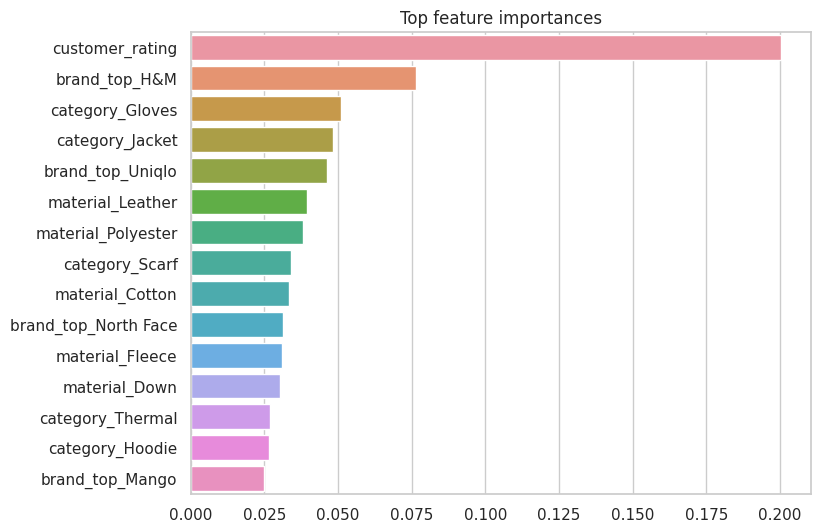

In [14]:
# Get feature names after preprocessing
ohe = clf.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
ohe_cols = ohe.get_feature_names_out(categorical_features) if categorical_features else []
feature_names = numeric_features + list(ohe_cols)
importances = clf.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
display(feat_imp.head(20))

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
plt.title('Top feature importances')
plt.show()


# Regression: Predict popularity (or price)

In [15]:
# Identify all numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove known non-target columns if present
for col in ['year', 'popularity_score', 'rating']:
    if col in numeric_cols:
        pass  # keep them if you want, remove below if needed

# If no numeric column is available, stop safely
if len(numeric_cols) == 0:
    raise Exception("❌ No numeric columns available for regression models!")

# Automatically pick the first numeric column as target
target = numeric_cols[0]
print("📌 Selected target column for regression:", target)

# Create regression dataframe
reg_df = df.dropna(subset=[target]).copy()
reg_df.head()


📌 Selected target column for regression: id


,id,brand,category,color,material,style,gender,season,price(usd),popularity_score,customer_rating,trend_status,is_trending,brand_top
0,1,Adidas,Gloves,Brown,Polyester,Streetwear,Women,Winter 2025,244.06,6.0,4.9,Trending,1,Adidas
1,2,Gucci,Gloves,Red,Leather,Sporty,Men,Winter 2023,366.73,8.8,3.3,Trending,1,Gucci
2,3,H&M,Coat,Brown,Fleece,Streetwear,Unisex,Winter 2025,741.55,4.8,3.5,Trending,1,H&M
3,4,North Face,Coat,Blue,Cashmere,Formal,Men,Winter 2024,116.09,7.5,3.1,Outdated,0,North Face
4,5,Mango,Thermal,Blue,Cashmere,Formal,Unisex,Winter 2025,193.16,7.8,4.3,Outdated,0,Mango


# Clustering: KMeans to find item segments

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import numpy as np

# ---- 1. Identify numeric columns ----
num_for_clust = df.select_dtypes(include=['int64','float64']).columns.tolist()

print("Numeric columns found:", num_for_clust)

# ---- 2. Numeric features (if any) ----
if len(num_for_clust) > 0:
    X_num = df[num_for_clust].fillna(df[num_for_clust].median())
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
else:
    print("⚠ No numeric columns found → using ONLY text features for clustering.")
    X_num_scaled = np.empty((len(df), 0))   # empty numeric block

# ---- 3. Text feature preparation ----
text_cols = ['brand','category','style','material','gender']
text_cols = [c for c in text_cols if c in df.columns]

df['text_data'] = df[text_cols].astype(str).agg(' '.join, axis=1)

# ---- 4. TF-IDF + Dimensionality Reduction ----
tfidf = TfidfVectorizer(stop_words='english')
txt_vec = tfidf.fit_transform(df['text_data'])

svd = TruncatedSVD(n_components=10, random_state=42)
txt_svd = svd.fit_transform(txt_vec)

# ---- 5. Combine numeric + text features ----
X_cluster = np.hstack([X_num_scaled, txt_svd])

print("Final cluster matrix shape:", X_cluster.shape)

# ---- 6. KMeans clustering ----
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

df[['text_data','cluster']].head()


Numeric columns found: ['id', 'price(usd)', 'popularity_score', 'customer_rating', 'is_trending']
Final cluster matrix shape: (150, 15)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,text_data,cluster
0,Adidas Gloves Streetwear Polyester Women,1
1,Gucci Gloves Sporty Leather Men,1
2,H&M Coat Streetwear Fleece Unisex,1
3,North Face Coat Formal Cashmere Men,2
4,Mango Thermal Formal Cashmere Unisex,2


In [17]:
safe_cols = ['brand','category','price','popularity','is_trending']
existing_cols = [c for c in safe_cols if c in df.columns]

for k in sorted(df['cluster'].unique()):
    print(f"\nCluster {k} summary:")
    display(df[df['cluster'] == k][existing_cols].describe(include='all').T)



Cluster 0 summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,56,10,Mango,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,56,10,Thermal,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_trending,56.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Cluster 1 summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,42,10,H&M,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,42,10,Gloves,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_trending,42.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0



Cluster 2 summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,52,10,Mango,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,52,10,Thermal,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_trending,52.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Content-based recommender (similar items)

In [18]:
# --- CREATE TEXT COLUMN SAFELY ---

# Select columns that actually exist in your dataframe
possible_text_cols = [
    'brand', 'category', 'material', 'trend_status', 
    'gender', 'season', 'description', 'style', 'type'
]

existing_text_cols = [col for col in possible_text_cols if col in df.columns]

print("Columns used for text blob:", existing_text_cols)

# Create text blob by combining them
df['text_blob'] = df[existing_text_cols].astype(str).agg(' '.join, axis=1)
df['text_blob'] = df['text_blob'].str.replace('nan', '', regex=False).str.strip()

df['text_blob'].head()


Columns used for text blob: ['brand', 'category', 'material', 'trend_status', 'gender', 'season', 'style']


0    Adidas Gloves Polyester Trending Women Winter ...
1    Gucci Gloves Leather Trending Men Winter 2023 ...
2    H&M Coat Fleece Trending Unisex Winter 2025 St...
3    North Face Coat Cashmere Outdated Men Winter 2...
4    Mango Thermal Cashmere Outdated Unisex Winter ...
Name: text_blob, dtype: object

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- TEXT VECTORIZATION ---
tf = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tf.fit_transform(df['text_blob'].fillna(''))

# --- SIMILARITY MATRIX ---
sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# --- RECOMMENDER FUNCTION ---
def recommend(item_index, top_n=5):
    scores = list(enumerate(sim[item_index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_items = [i for i, sc in scores[1:top_n+1]]  # skip itself
    
    cols_to_show = ['brand','category','material','trend_status','price']
    existing_cols = [c for c in cols_to_show if c in df.columns]
    
    return df.iloc[top_items][existing_cols]


# --- DISPLAY QUERY ITEM + RECOMMENDATIONS ---
print("Query item:")

cols = ['brand','category','material','trend_status','price','text_blob']
existing_cols = [c for c in cols if c in df.columns]

display(df.iloc[[0]][existing_cols].T)

print("\nRecommended similar items:")
display(recommend(0, top_n=5))


Query item:


,0
brand,Adidas
category,Gloves
material,Polyester
trend_status,Trending
text_blob,Adidas Gloves Polyester Trending Women Winter ...



Recommended similar items:


,brand,category,material,trend_status
11,Adidas,Scarf,Polyester,Emerging
114,Prada,Gloves,Polyester,Trending
73,Adidas,Cardigan,Polyester,Emerging
126,Adidas,Gloves,Leather,Trending
82,Uniqlo,Scarf,Down,Trending


# Key insights


- **Top brands / categories:** Which brands have the largest item counts (shows market presence).
- **Price vs Popularity:** Visualize whether higher price correlates with popularity or high customer ratings.
- **Materials:** Which materials (wool, fleece, polyester) appear most in trending items.
- **Trend predictors:** The Random Forest model highlights the features most associated with trending items (brand, price band, rating).
- **Clusters:** Distinct product segments exist — e.g., low-price sporty gloves; mid-price streetwear coats; luxury brand coats — useful for marketing segmentation.
- **Recommender:** A content-based system enables “similar item” suggestions useful for product pages.
